In [40]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
con = duckdb.connect(":memory:", read_only=False)

In [4]:
con.sql(
    """
    CREATE OR REPLACE TABLE ganancia_maxima AS (
    SELECT
        foto_mes,
        numero_de_cliente,
        clase_ternaria
    FROM read_parquet('buckets/b1/datasets/processed/competencia_03_crudo.parquet')
    WHERE foto_mes <= 202107
    )
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
con.sql(
    """
    SELECT
        *
    FROM ganancia_maxima
    LIMIT 10
    """
)

┌──────────┬───────────────────┬────────────────┐
│ foto_mes │ numero_de_cliente │ clase_ternaria │
│  int64   │       int64       │    varchar     │
├──────────┼───────────────────┼────────────────┤
│   201901 │          29183981 │ CONTINUA       │
│   201902 │          29183981 │ CONTINUA       │
│   201903 │          29183981 │ CONTINUA       │
│   201904 │          29183981 │ CONTINUA       │
│   201905 │          29183981 │ CONTINUA       │
│   201906 │          29183981 │ CONTINUA       │
│   201907 │          29183981 │ CONTINUA       │
│   201908 │          29183981 │ CONTINUA       │
│   201909 │          29183981 │ CONTINUA       │
│   201910 │          29183981 │ CONTINUA       │
├──────────┴───────────────────┴────────────────┤
│ 10 rows                             3 columns │
└───────────────────────────────────────────────┘

In [8]:
con.sql(
    """
    CREATE OR REPLACE TABLE ganancia_maxima AS (
        SELECT
            *,
            CASE 
                WHEN clase_ternaria = 'BAJA+2' THEN 270000
                ELSE 0
            END AS weights
        FROM ganancia_maxima
    )
    """
)

In [9]:
con.sql(
    """
    SELECT
        *
    FROM ganancia_maxima
    LIMIT 10
    """
)

┌──────────┬───────────────────┬────────────────┬─────────┐
│ foto_mes │ numero_de_cliente │ clase_ternaria │ weights │
│  int64   │       int64       │    varchar     │  int32  │
├──────────┼───────────────────┼────────────────┼─────────┤
│   201901 │          29183981 │ CONTINUA       │       0 │
│   201902 │          29183981 │ CONTINUA       │       0 │
│   201903 │          29183981 │ CONTINUA       │       0 │
│   201904 │          29183981 │ CONTINUA       │       0 │
│   201905 │          29183981 │ CONTINUA       │       0 │
│   201906 │          29183981 │ CONTINUA       │       0 │
│   201907 │          29183981 │ CONTINUA       │       0 │
│   201908 │          29183981 │ CONTINUA       │       0 │
│   201909 │          29183981 │ CONTINUA       │       0 │
│   201910 │          29183981 │ CONTINUA       │       0 │
├──────────┴───────────────────┴────────────────┴─────────┤
│ 10 rows                                       4 columns │
└───────────────────────────────────────

In [16]:
df = con.sql(
    """
    SELECT
        foto_mes,
        SUM(weights) AS ganancia_maxima
    FROM ganancia_maxima
    GROUP BY
        foto_mes
    """
).to_df()

In [35]:
df.head()

,foto_mes,ganancia_maxima
0,201901,193050000.0
1,201902,184680000.0
2,201903,196830000.0
3,201904,139860000.0
4,201905,183600000.0


In [29]:
df = df.fillna(np.nan)

In [30]:
df["foto_mes"].unique()

array([201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
       201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
       202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
       202101, 202102, 202103, 202104, 202105, 202106, 202107])

In [33]:
df.isnull().sum()

foto_mes           0
ganancia_maxima    0
dtype: int64

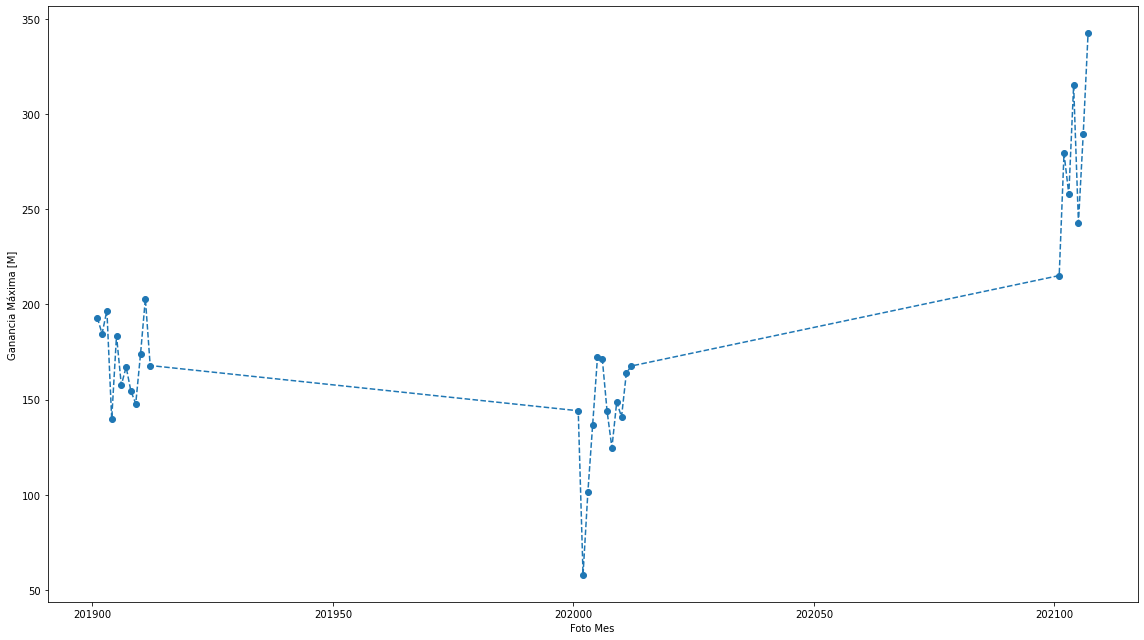

In [50]:
plt.figure(figsize=(16,9))
plt.plot(df["foto_mes"].values,df["ganancia_maxima"].values/1000000, 'o--')
plt.xlabel("Foto Mes")
plt.xticks(df["foto_mes"].values)
plt.ylabel("Ganancia Máxima [M]")
plt.tight_layout()
plt.show()

In [ ]:
df.to_parquet("buckets/b1/processed/ganancia_maxima.parquet")